### Top Conditions by Day: Panel Overview

This notebook creates a four–panel visualization to summarize how the most common clinical conditions evolve over time.  
The panel combines multiple perspectives:

1. **Daily Condition Counts (Line Plot)** – absolute frequency trends over time  
2. **Condition Composition per Day (Stacked Area Plot)** – proportional distribution of conditions  
3. **Condition × Day Heatmap** – intensity and concentration across time  
4. **Frequency Plot (Horizontal Bar Chart)** – total counts representing frequency

Together, these plots offer a broad, multi-angle view of temporal condition behavior, making it easier to detect spikes, observe shifts in condition composition, and compare overall prevalence.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [2]:
#  Setup 
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 6)

# Initialize random number generator for reproducibility, Panda's utilizes NumPy module not "random"
np.random.seed(42)

In [3]:
# Load data
df = pd.read_csv("final_with_deceased.csv")

### Data Preparation

Before building the visualizations, the dataset undergoes several preprocessing steps:

- **Condition cleaning:** Multi-condition strings (e.g., `"Cough : Fever : Dyspnea"`) are split into individual items using a robust regex-based function.
- **Long-format expansion:** Each condition becomes a separate row via `explode()`, allowing proper counting and grouping.
- **Date parsing:** Visit timestamps are converted into datetime objects to ensure accurate filtering and time-based grouping.
- **Top condition selection:** Only the most frequent conditions (Top 10) are kept to maintain clarity and avoid overcrowding.
- **Daily count grid:** A complete day × condition grid is created to ensure continuity across all plots, even when a condition has zero occurrences on certain days.

This structure ensures fully reproducible, consistent visualizations across all subplots.


In [4]:
import re

# robust split on ":" allowing extra spaces; keep NaN if empty
def split_conditions(s):
    if pd.isna(s) or str(s).strip() == "":
        return []
    # split on ":" with optional surrounding spaces
    parts = re.split(r"\s*:\s*", str(s))
    # normalize: strip, drop empties, lower (or title-case if you prefer)
    parts = [p.strip() for p in parts if p and p.strip()]
    return parts

# apply once to create a list-typed column
df["condition_list"] = df["condition"].map(split_conditions)

In [5]:
cond_long = (
    df[["visit_occurrence_id", "person_id", "visit_start_date"]]
      .assign(condition_item=df["condition_list"])
      .explode("condition_item", ignore_index=True)
)

# drop rows where no condition exists after cleaning
cond_long = cond_long.dropna(subset=["condition_item"])

# (optional) dedupe within visit in case the same condition appears twice
date_col = "visit_start_date" if "visit_start_date" in cond_long.columns else "date"
cond_long = cond_long.drop_duplicates(subset=["visit_occurrence_id", "condition_item"])
cond_long[date_col] = pd.to_datetime(cond_long[date_col], errors="coerce")

In [6]:
TOP_K = 10
START = "2020-02-01"
END   = "2020-04-01"
date_col = "visit_start_date"

In [7]:
# Filter to window
mask = (cond_long[date_col] >= START) & (cond_long[date_col] <= END)
win  = cond_long.loc[mask].dropna(subset=["condition_item"])


In [8]:
# Identify top conditions
top_conditions = (
    win["condition_item"]
    .value_counts()
    .head(TOP_K)
    .index
    .tolist()
)

win = win[win["condition_item"].isin(top_conditions)]

In [9]:
# ---- DAILY COUNTS ----
daily = (
    win.assign(day=win[date_col].dt.floor("D"))
       .groupby(["day", "condition_item"])
       .size()
       .rename("count")
       .reset_index()
)

# Ensure complete grid (no missing days or conditions)
full_idx = pd.MultiIndex.from_product(
    [pd.date_range(START, END, freq="D"), top_conditions],
    names=["day", "condition_item"]
)

daily = (
    daily.set_index(["day","condition_item"])
         .reindex(full_idx, fill_value=0)
         .reset_index()
)

In [10]:
# Pivot for heatmap / stacked area
wide = daily.pivot(index="day", columns="condition_item", values="count")
share = wide.div(wide.sum(axis=1).replace(0, np.nan), axis=0).fillna(0) * 100

### Panel of Plots: What This Code Cell Does

This code builds a 2×2 panel of plots that summarizes how the top clinical conditions behave over time in the selected date range.

- **Top-left: Daily Condition Counts (Line Plot)**  
  Each line is one condition. The y-axis shows how many visits per day had that condition. This makes it easy to see spikes, rise/decay patterns, and how conditions move together over time.

- **Top-right: Condition Composition per Day (Stacked Area Plot)**  
  Here we convert daily counts to percentages. The stacked areas show how the *mix* of conditions changes day by day, even if total visit volume changes. It highlights which conditions are dominant vs. minor at different points in time.

- **Bottom-left: Condition × Day Heatmap**  
  Rows are conditions, columns are days, and color intensity is the daily count. This gives a compact view of where activity is concentrated (dark bands) and where it is minimal.

- **Bottom-right: Total Frequency of Top Conditions (Mirrored Bar Plot)**  
  This horizontal bar chart shows the total number of visits for each condition across the whole window. The bars are mirrored right→left for visual symmetry with the panel, and the numeric labels at the bar ends show the exact counts.

Together, these four plots provide a quick, multi-angle summary of trends (line plot), relative composition (area plot), temporal intensity (heatmap), and overall prevalence (bar plot) for the top conditions.


/tmp/ipykernel_2032118/2260410317.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2032118/2260410317.py:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels([f"{abs(int(x)):,}" for x in xticks])


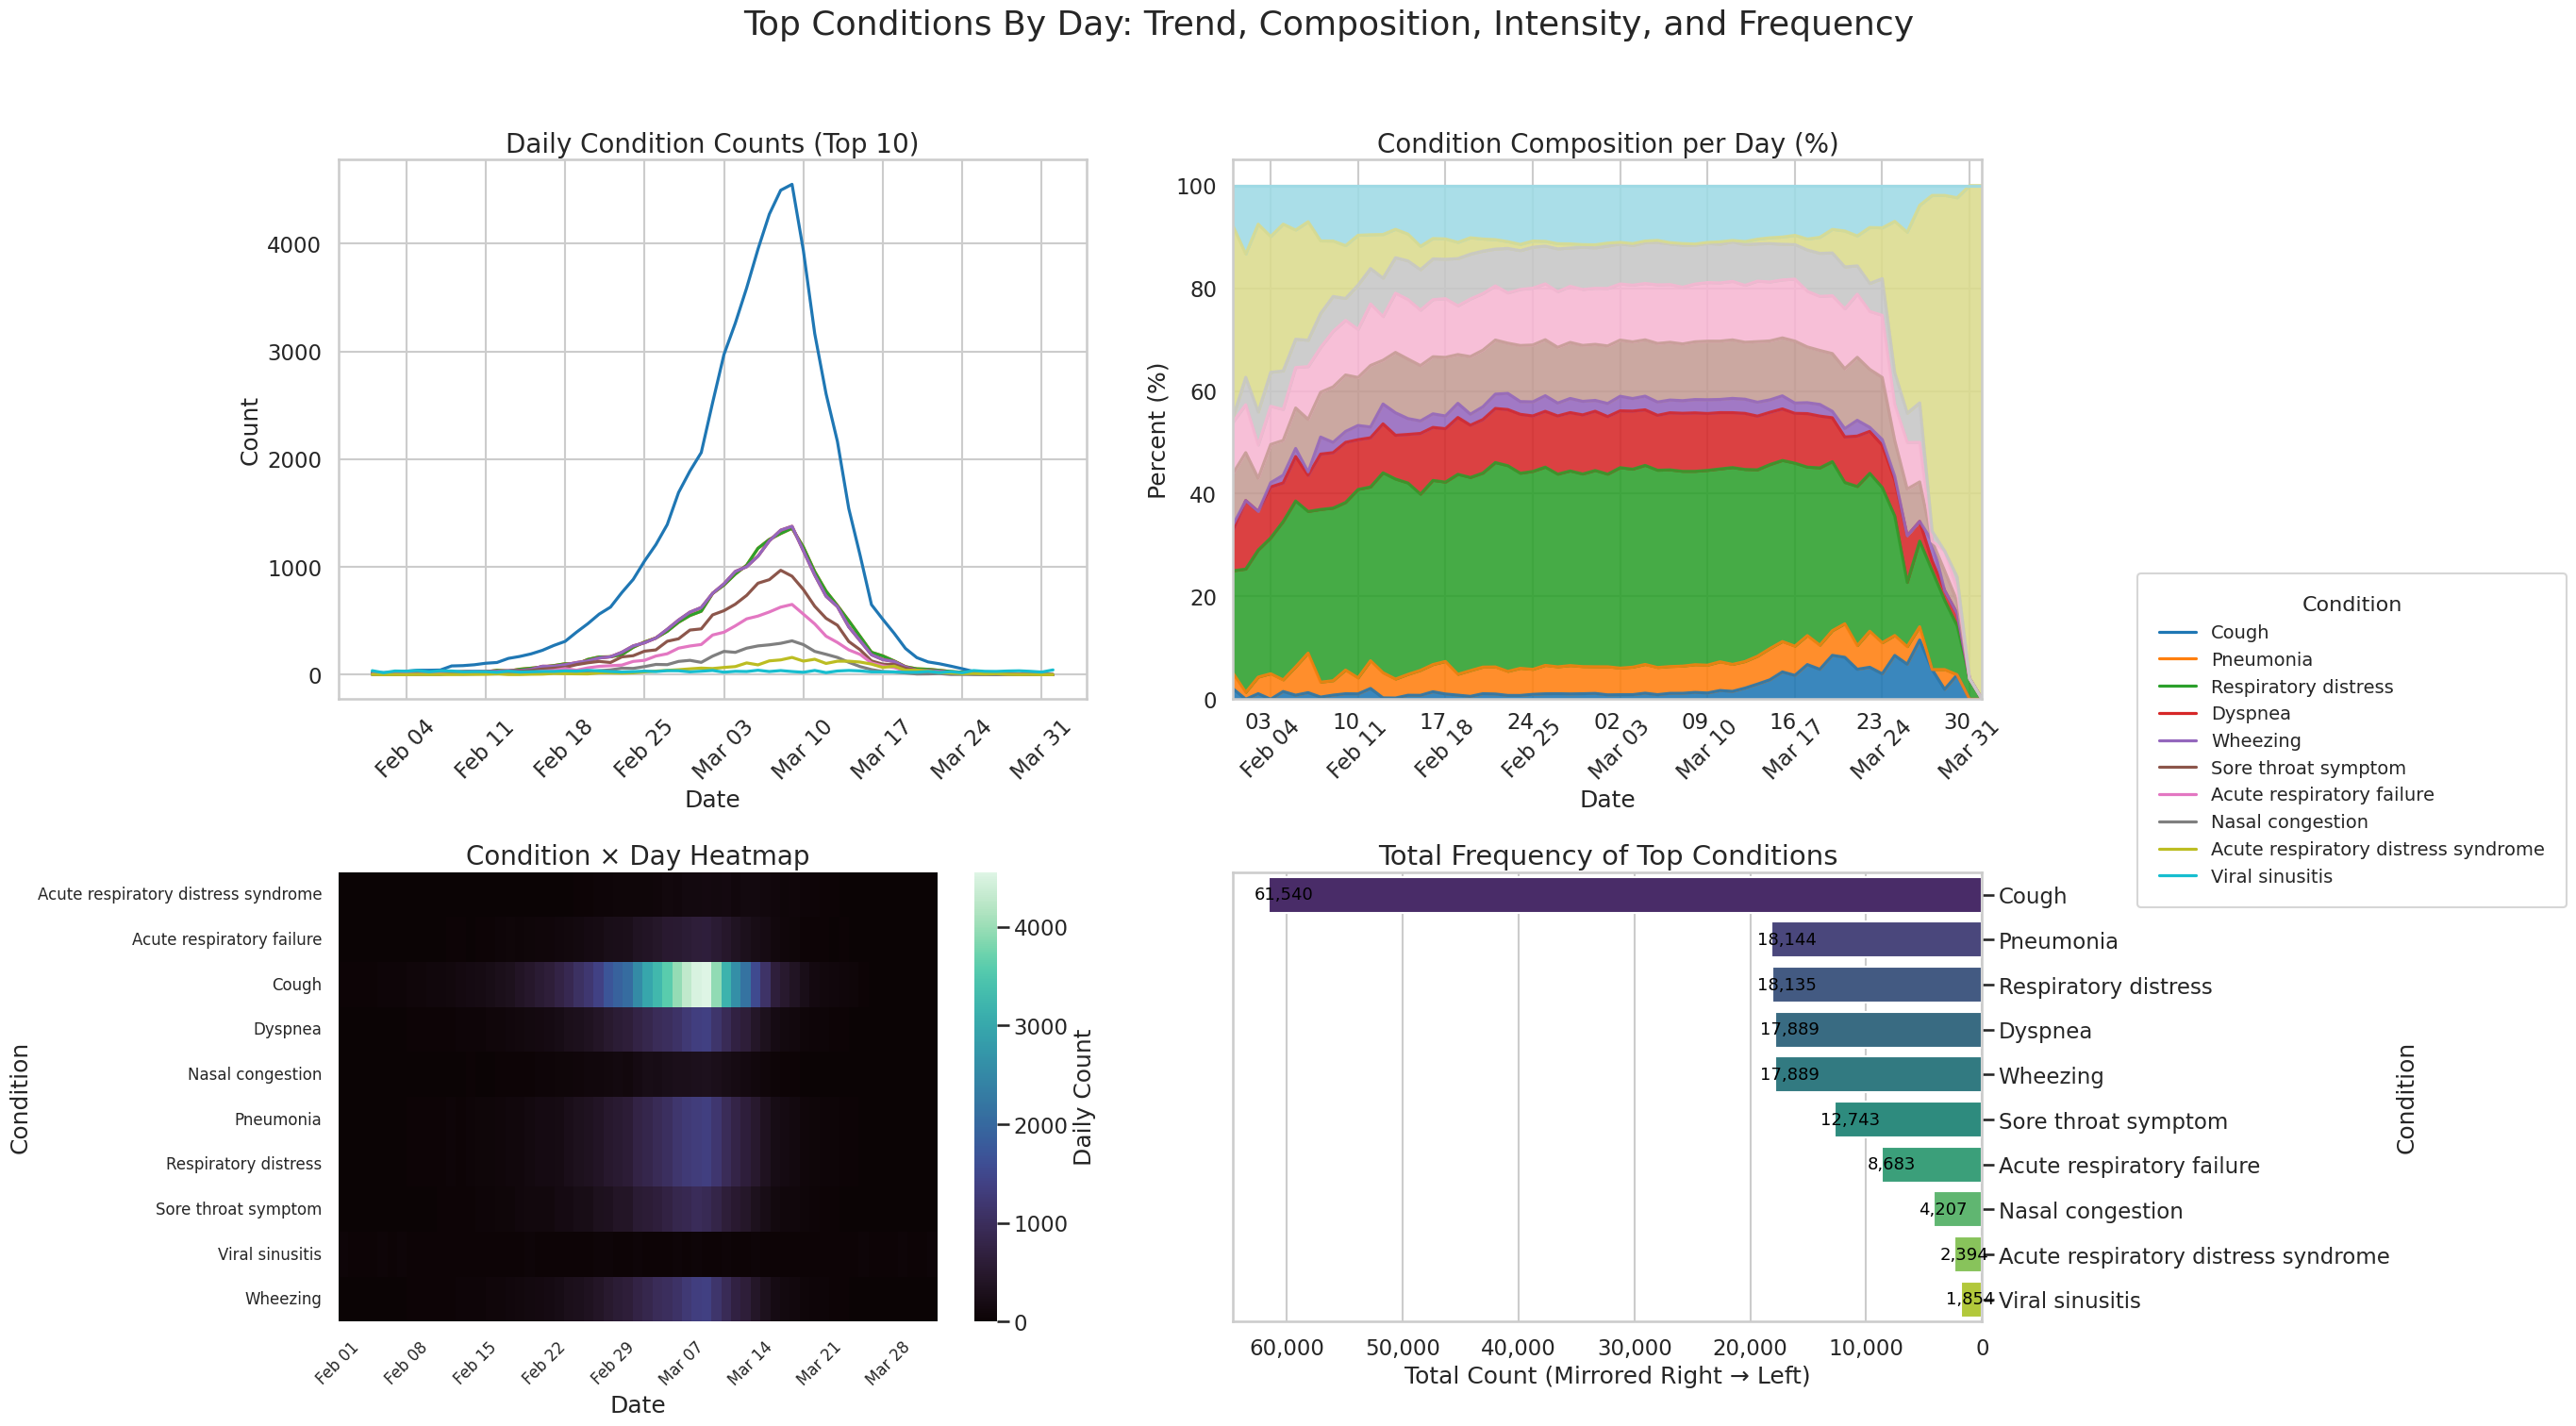

In [11]:
# -------- PANEL LAYOUT WITH LEGEND COLUMN --------
fig = plt.figure(figsize=(28, 16))

# Create a 2×3 grid, reserving the 3rd column ONLY for legends
gs = fig.add_gridspec(2, 3, width_ratios=[3.5, 3.5, 1.2], 
                      height_ratios=[1.2, 1], wspace=0.25, hspace=0.35)

ax1 = fig.add_subplot(gs[0,0])     # line plot
ax2 = fig.add_subplot(gs[0,1])     # area plot
ax3 = fig.add_subplot(gs[1,0])     # heatmap
ax4 = fig.add_subplot(gs[1,1])     # barplot
legend_ax = fig.add_subplot(gs[:,2])  # full-height legend column
legend_ax.axis("off")  # hide this axis; used only for legend placement

fig.suptitle("Top Conditions By Day: Trend, Composition, Intensity, and Frequency",
             fontsize=26, y=0.98)




# ---------------------------------------------------------------------
#                     1. DAILY LINE PLOT
# ---------------------------------------------------------------------
palette = sns.color_palette("tab10", n_colors=len(top_conditions))

line = sns.lineplot(
    data=daily,
    x="day", y="count",
    hue="condition_item",
    ax=ax1,
    palette=palette,
    linewidth=2.3
)

ax1.set_title("Daily Condition Counts (Top 10)", fontsize=20)
ax1.set_xlabel("Date")
ax1.set_ylabel("Count")

ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax1.tick_params(axis="x", rotation=45)

# Extract legend handles for unified legend panel
handles1, labels1 = ax1.get_legend_handles_labels()
ax1.legend().remove()  # remove local legend to avoid clutter




# ---------------------------------------------------------------------
#                   2. STACKED AREA COMPOSITION PLOT
# ---------------------------------------------------------------------
areas = share.plot.area(ax=ax2, cmap="tab20", alpha=0.88)

ax2.set_title("Condition Composition per Day (%)", fontsize=20)
ax2.set_xlabel("Date")
ax2.set_ylabel("Percent (%)")

ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax2.tick_params(axis="x", rotation=45)

# Remove local legend from area plot as well
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend().remove()




# ---------------------------------------------------------------------
#                   3. HEATMAP (No Borders)
# ---------------------------------------------------------------------
sns.heatmap(
    wide.T,
    cmap="mako",
    ax=ax3,
    cbar_kws={"label": "Daily Count"},
    linewidths=0,
    linecolor=None
)

ax3.set_title("Condition × Day Heatmap", fontsize=20)
ax3.set_xlabel("Date")
ax3.set_ylabel("Condition")

num_days = len(wide.index)
tick_step = max(1, num_days // 8)

ax3.set_xticks(np.arange(0, num_days, tick_step))
ax3.set_xticklabels(
    [wide.index[i].strftime('%b %d') for i in range(0, num_days, tick_step)],
    rotation=45, fontsize=12
)
ax3.set_yticklabels(ax3.get_yticklabels(), fontsize=12)




# ---------------------------------------------------------------------
#                4. TOTAL CONDITION FREQUENCY BARPLOT
# ---------------------------------------------------------------------
freq = (
    win["condition_item"]
    .value_counts()
    .loc[top_conditions]
    .sort_values(ascending=False)  # largest at top
)

# Reverse the values by negating them
mirror_values = -freq.values

sns.barplot(
    x=mirror_values,               # NEGATIVE values → bars extend right→left
    y=freq.index,
    palette="viridis",
    ax=ax4,
    orient="h"
)

ax4.set_title("Total Frequency of Top Conditions", fontsize=21)
ax4.set_xlabel("Total Count (Mirrored Right → Left)")
ax4.set_ylabel("Condition")

# Flip x-axis so that positive numbers appear on ticks even though bars are negative
xticks = ax4.get_xticks()
ax4.set_xticklabels([f"{abs(int(x)):,}" for x in xticks])

# Keep labels on the left
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")

# Add labels at the LEFT end of each bar
for i, val in enumerate(freq.values):
    ax4.text(
        -val - max(freq.values)*0.02,   # shift slightly further left
        i,
        f"{val:,}",
        va="center",
        fontsize=13,
        color="black"
    )



# ---------------------------------------------------------------------
#                     UNIFIED LEGEND PANEL
# ---------------------------------------------------------------------
# Combine legend labels from line & area plots
handles = handles1
labels = labels1

legend_ax.legend(
    handles, labels,
    title="Condition",
    loc="center left",
    fontsize=14,
    title_fontsize=16,
    frameon=True,
    borderpad=1.2
)

plt.show()